In [1]:
import sys
sys.path.append('src/')
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
import ast
import matplotlib.pyplot as plt
import numpy as np

# panda view settings
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', 500)  # Display full text in columns

In [2]:
combined_training_bart = pd.read_csv('results/training/bart-large/combined_training_results.csv')
combined_training_debertav3 = pd.read_csv('results/training/debertav3/combined_deberta_trainng_results.csv')

combined_test_bart = pd.read_csv('results/test/bart-large/combined_test_results.csv')
combined_test_debertav3 = pd.read_csv('results/test/debertav3/combined_test_results_deberta.csv')

# Training data analysis

## Test f1 scores

In [3]:
def set_predictions_multiple(df, max_correct_threshold=1):
    def is_bias(row, n_labels):
        labels = ast.literal_eval(row['labels'])
        if sum(label == 'entailment' for label in labels) >= n_labels:
            return 'bias'
        else:
            return 'neutral'

    label_correctness_list = []

    for _, row in df.iterrows():
        row_results = []

        for n in range(1, max_correct_threshold + 1):
            result = is_bias(row, n)
            row_results.append(result)

        label_correctness_list.append(row_results)

    # Add the list as the 'is_label_correct' column in the DataFrame
    df['predicted'] = pd.Series(label_correctness_list)

    return df


In [4]:
df_training_multiple_bart = set_predictions_multiple(combined_training_bart, 15)
df_training_multiple_debertav3 = set_predictions_multiple(combined_training_debertav3, 15)

In [5]:
np.random.seed(42)

In [6]:
def convert_to_binary(label_array, target_label):
    return [1 if label == target_label else 0 for label in label_array]

In [7]:
def calculate_multiple_f1_scores(df):
    f1_score_values = [] 

    for idx in range(len(df['predicted'].iloc[0])):
        predicted_labels = df['predicted'].apply(lambda x: x[idx])
        actual = df['bias']

        # Convert predicted_labels to binary (1 for target_label, 0 otherwise)
        predicted_binary_bias = convert_to_binary(predicted_labels, 'bias')
        actual_binary_bias = convert_to_binary(actual, 'bias')

        predicted_binary_neutral = convert_to_binary(predicted_labels, 'neutral')
        actual_binary_neutral = convert_to_binary(actual, 'neutral')

        f1_bias = f1_score(actual_binary_bias, predicted_binary_bias)
        f1_neutral =  f1_score(actual_binary_neutral, predicted_binary_neutral)

        f1_score_values.append((f1_bias + f1_neutral) / 2)

    return f1_score_values

In [8]:
f1_scores_training_deberta = calculate_multiple_f1_scores(df_training_multiple_debertav3)
print('F1 scores training deberta-v3:')
print(f1_scores_training_deberta)

f1_scores_training_bart = calculate_multiple_f1_scores(df_training_multiple_bart)
print('F1 scores training bart-large:')
print(f1_scores_training_bart)

F1 scores training deberta-v3:
[0.6376965879034648, 0.5720069675190655, 0.4999336700477346, 0.4462344594793496, 0.38593750000000004, 0.35776134304195994, 0.3497735709081982, 0.34454365185701274, 0.34315305713594546, 0.33615436987753483, 0.33615436987753483, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
F1 scores training bart-large:
[0.6246005257162046, 0.6472744365520144, 0.6252075022617292, 0.575503530286139, 0.5267880152894934, 0.4739560545499039, 0.4318651196341896, 0.3915961375073525, 0.3661499709257056, 0.3516009695114172, 0.34117369633956807, 0.337272404633105, 0.3330504879083581, 0.3330504879083581, 0.3333333333333333]


## Check neutral prediction numbers

In [9]:
neutral_rows = df_training_multiple_debertav3[df_training_multiple_debertav3['predicted'].apply(lambda x: all(item == 'neutral' for item in x))]
print(len(neutral_rows))

neutral_rows = df_training_multiple_bart[df_training_multiple_bart['predicted'].apply(lambda x: all(item == 'neutral' for item in x))]
print(len(neutral_rows))

681
371


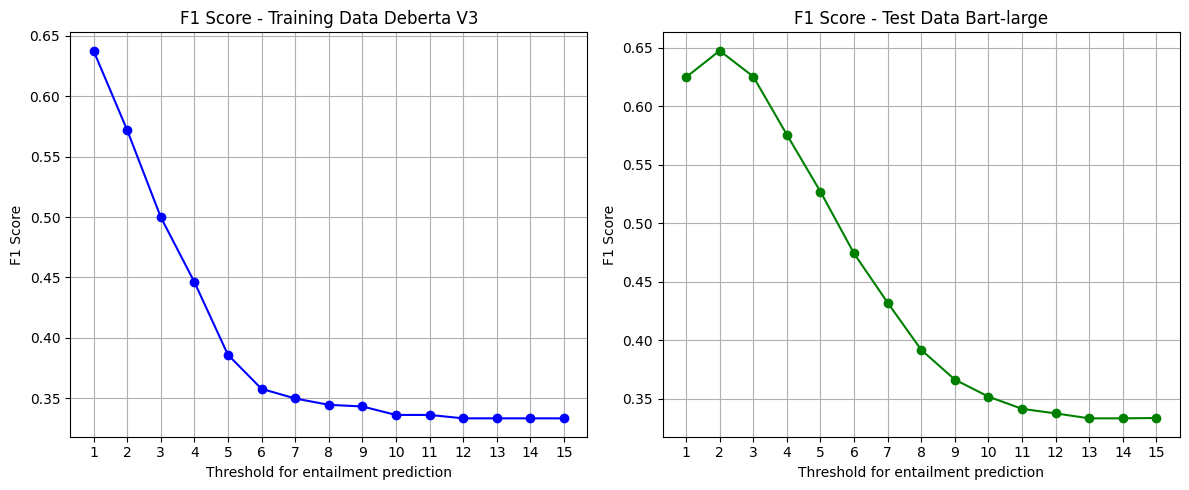

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot for training data
plt.subplot(1, 2, 1)
plt.plot(range(1, len(f1_scores_training_deberta) + 1), f1_scores_training_deberta, marker='o', color='blue')
plt.xlabel('Threshold for entailment prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score - Training Data Deberta V3')
plt.xticks(range(1, len(f1_scores_training_deberta) + 1))
plt.grid()

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(range(1, len(f1_scores_training_bart) + 1), f1_scores_training_bart, marker='o', color='green')
plt.xlabel('Threshold for entailment prediction')
plt.ylabel('F1 Score')
plt.title('F1 Score - Test Data Bart-large')
plt.xticks(range(1, len(f1_scores_training_bart) + 1))
plt.grid()

plt.tight_layout()
plt.show()


## AUC (Area under curve)

In [11]:
def calculate_entailment_ratio(labels):
    labels = ast.literal_eval(labels)
    entailment_count = sum(label == 'entailment' for label in labels) 
    return entailment_count / len(labels)

In [12]:
# Add entailment ratios to df
df_training_multiple_debertav3['entailment_ratio'] = df_training_multiple_debertav3['labels'].apply(calculate_entailment_ratio)
df_training_multiple_bart['entailment_ratio'] = df_training_multiple_bart['labels'].apply(calculate_entailment_ratio)

In [13]:
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_training_multiple_debertav3['predicted']))
positive_class = 'bias'

y_true = (df_training_multiple_debertav3['bias'] == positive_class).astype(int)
y_scores = df_training_multiple_debertav3['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for training data debertav3: {auc_roc}")

AUC-ROC Score for training data debertav3: 0.6509794495270282


In [14]:
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_training_multiple_bart['predicted']))
positive_class = 'bias'

y_true = (df_training_multiple_bart['bias'] == positive_class).astype(int)
y_scores = df_training_multiple_bart['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for training data bart-large: {auc_roc}")

AUC-ROC Score for training data bart-large: 0.6764733018666356


# Test data analysis

In [21]:
df_test_multiple_bart = set_predictions_multiple(combined_test_bart, 2)
df_test_multiple_debertav3 = set_predictions_multiple(combined_test_debertav3, 1)

In [22]:
f1_scores_test_deberta = calculate_multiple_f1_scores(df_test_multiple_debertav3)
print('F1 scores test deberta-v3:')
print(f1_scores_test_deberta)

f1_scores_test_bart = calculate_multiple_f1_scores(df_test_multiple_bart)
print('F1 scores test bart-large:')
print(f1_scores_test_bart)

F1 scores test deberta-v3:
[0.6387497727310293]
F1 scores test bart-large:
[0.6409096012431608, 0.654846494774973]


In [26]:
# Add entailment ratios to df
df_test_multiple_debertav3['entailment_ratio'] = df_test_multiple_debertav3['labels'].apply(calculate_entailment_ratio)
df_test_multiple_bart['entailment_ratio'] = df_test_multiple_bart['labels'].apply(calculate_entailment_ratio)

In [27]:
df_test_multiple_debertav3['entailment_ratio'] = df_test_multiple_debertav3['labels'].apply(calculate_entailment_ratio)
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_test_multiple_debertav3['predicted']))
positive_class = 'bias'

y_true = (df_test_multiple_debertav3['bias'] == positive_class).astype(int)
y_scores = df_test_multiple_debertav3['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for deberta data: {auc_roc}")

AUC-ROC Score for deberta data: 0.6465139049366653


In [29]:
df_test_multiple_bart['entailment_ratio'] = df_test_multiple_bart['labels'].apply(calculate_entailment_ratio)
# Get unique class labels from 'predicted' column
class_labels = np.unique(np.concatenate(df_test_multiple_bart['predicted']))
positive_class = 'bias'

y_true = (df_test_multiple_bart['bias'] == positive_class).astype(int)
y_scores = df_test_multiple_bart['entailment_ratio']
auc_roc = roc_auc_score(y_true, y_scores)
print(f"AUC-ROC Score for bart data: {auc_roc}")

AUC-ROC Score for bart data: 0.6873841076638463


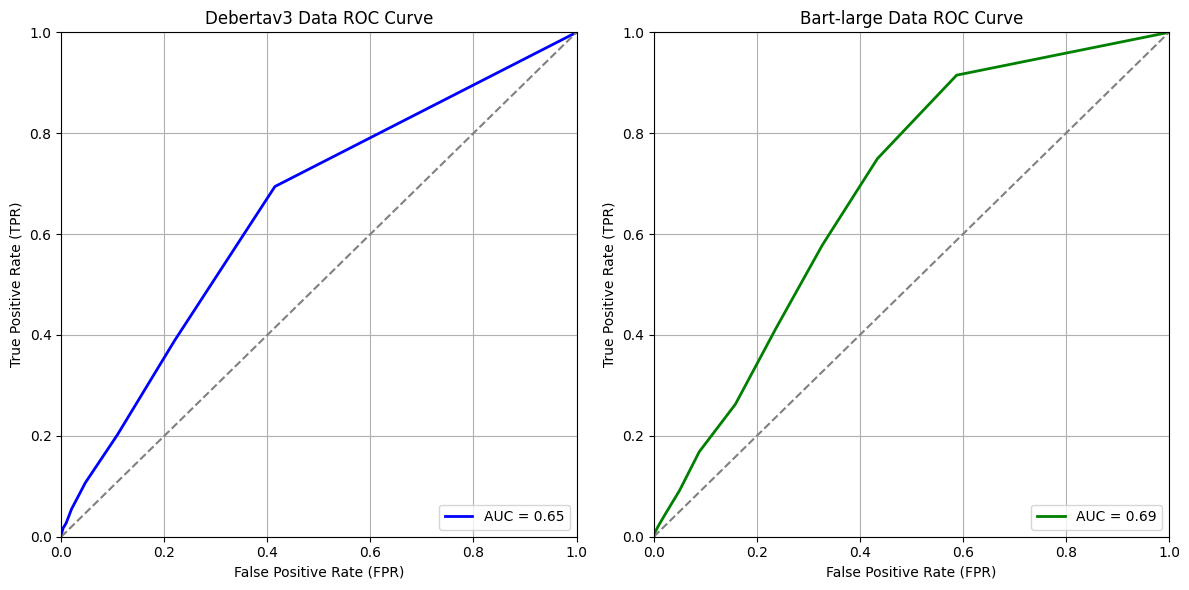

In [33]:
# Convert the true labels to binary values (0 for 'neutral', 1 for 'bias')
y_true_deberta = (df_test_multiple_debertav3['bias'] == 'bias').astype(int)
y_true_bart = (df_test_multiple_bart['bias'] == 'bias').astype(int)

# Get the predicted ratios from the 'entailment_ratio' column
y_scores_deberta = df_test_multiple_debertav3['entailment_ratio']
y_scores_bart = df_test_multiple_bart['entailment_ratio']

# Calculate the ROC curve for training data
fpr_deberta, tpr_deberta, thresholds_train = roc_curve(y_true_deberta, y_scores_deberta)
roc_auc_deberta = auc(fpr_deberta, tpr_deberta)

# Calculate the ROC curve for test data
fpr_bart, tpr_bart, thresholds_train = roc_curve(y_true_bart, y_scores_bart)
roc_auc_bart = auc(fpr_bart, tpr_bart)

# Plot the ROC curves side by side
plt.figure(figsize=(12, 6))

# Plot for training data
plt.subplot(1, 2, 1)
plt.plot(fpr_deberta, tpr_deberta, color='blue', lw=2, label=f'AUC = {roc_auc_deberta:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Debertav3 Data ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Plot for test data
plt.subplot(1, 2, 2)
plt.plot(fpr_bart, tpr_bart, color='green', lw=2, label=f'AUC = {roc_auc_bart:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Bart-large Data ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()
